In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 21.5 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import random
import os
import shutil
import numpy as np
from pathlib import Path

# Preparing Datset

In [2]:
dataset_root = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
splits_root = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt"
output_root = "/kaggle/working/yolo_dataset"

football_sequences = set()
football_file = os.path.join(splits_root, "football.txt")

with open(football_file, "r") as f:
    football_sequences = set(line.strip() for line in f)

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "labels"), exist_ok=True)

def convert_mot_to_yolo(sequence_path, split):
    
    seqinfo_path = os.path.join(sequence_path, "seqinfo.ini")
    with open(seqinfo_path, "r") as f:
        seqinfo = {line.split('=')[0]: line.split('=')[1].strip() for line in f if '=' in line}
    img_width = int(seqinfo["imWidth"])
    img_height = int(seqinfo["imHeight"])
    
    gt_path = os.path.join(sequence_path, "gt/gt.txt")
    with open(gt_path, "r") as f:
        annotations = [line.strip().split(",") for line in f]
    
    frame_annotations = {}
    for ann in annotations:
        frame_id, _, x, y, w, h, _, class_id, _ = map(float, ann[:9])
        frame_id = int(frame_id)
        
        # Normalize
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        
        if frame_id not in frame_annotations:
            frame_annotations[frame_id] = []
        frame_annotations[frame_id].append(f"{int(class_id-1)} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    
    for frame_id, ann_list in frame_annotations.items():
        img_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.jpg"  # Add sequence name to make filename unique
        label_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.txt"
        
        img_src = os.path.join(sequence_path, "img1", f"{frame_id:06d}.jpg")
        img_dst = os.path.join(output_root, split, "images", img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        
        label_dst = os.path.join(output_root, split, "labels", label_name)
        with open(label_dst, "w") as f:
            f.write("\n".join(ann_list))

for split in ["train", "val"]:
    split_file = os.path.join(splits_root, f"{split}.txt")
    
    with open(split_file, "r") as f:
        sequences = [line.strip() for line in f]
    
    for seq in sequences:
        if seq in football_sequences:  # Only process football sequences
            sequence_path = os.path.join(dataset_root, split, seq)
            if os.path.exists(sequence_path):
                convert_mot_to_yolo(sequence_path, split)

print("Conversion complete. YOLO dataset is in:", output_root)

Conversion complete. YOLO dataset is in: /kaggle/working/yolo_dataset


In [3]:
yaml_content = """path: /kaggle/working/yolo_dataset
train: train/images
val: val/images

nc: 1
names: ["player"]
"""

yaml_path = "/kaggle/working/yolo_dataset/sportsmot.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"YAML file created at: {yaml_path}")

YAML file created at: /kaggle/working/yolo_dataset/sportsmot.yaml


# Detection

## Training YOLO on SportsMOT

In [4]:
from ultralytics import YOLO

model.train(
    data="/kaggle/working/yolo_dataset/sportsmot.yaml",
    epochs=50,
    imgsz= 640
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 119MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/sportsmot.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 28.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/train/labels... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:09<00:00, 1134.97it/s]


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_dataset/val/labels... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:08<00:00, 1076.06it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000500.jpg: 1

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.45G     0.9855     0.7761     0.8653        192        640: 100%|██████████| 695/695 [02:19<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:51<00:00,  5.52it/s]


                   all       9058     117024      0.896      0.929      0.923      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.6G     0.8667     0.4865      0.842        180        640: 100%|██████████| 695/695 [02:14<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.81it/s]


                   all       9058     117024      0.901      0.917      0.939      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.51G     0.8415     0.4529     0.8378        187        640: 100%|██████████| 695/695 [02:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.893      0.926       0.93      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.51G     0.8242     0.4333     0.8341        185        640: 100%|██████████| 695/695 [02:12<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.85it/s]


                   all       9058     117024      0.887      0.927      0.922      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.51G     0.7881     0.4146     0.8286        182        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.895      0.942      0.924      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.55G     0.7679     0.4013      0.826        239        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.907      0.943      0.931      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.5G     0.7553      0.392     0.8232        178        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.915      0.939      0.932      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.42G     0.7428     0.3823      0.822        154        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024      0.923       0.94      0.942      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.51G     0.7322     0.3771     0.8211        235        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.907      0.916      0.928      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.5G     0.7208     0.3695     0.8191        204        640: 100%|██████████| 695/695 [02:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.86it/s]


                   all       9058     117024      0.914      0.933       0.94       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.5G     0.7149     0.3655     0.8181        179        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.917      0.931      0.937      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.52G     0.7034      0.358     0.8162        177        640: 100%|██████████| 695/695 [02:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.82it/s]


                   all       9058     117024      0.916      0.923      0.926      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.48G      0.704     0.3559      0.816        181        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.918      0.936      0.929      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.5G     0.6978     0.3531     0.8155        236        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.914      0.917      0.922      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.5G     0.6838     0.3457     0.8142        142        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024       0.91      0.925       0.92       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.52G      0.683     0.3445     0.8133        225        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.919      0.935      0.931      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.51G     0.6787     0.3408     0.8123        168        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.92it/s]


                   all       9058     117024       0.92      0.935      0.936      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.53G      0.673     0.3385     0.8115        253        640: 100%|██████████| 695/695 [02:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024      0.921      0.939      0.927      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.51G     0.6688     0.3359     0.8109        221        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.92it/s]


                   all       9058     117024      0.915      0.933      0.926      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.53G     0.6611     0.3312     0.8107        186        640: 100%|██████████| 695/695 [02:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.919      0.931      0.932      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.51G     0.6594     0.3301     0.8105        178        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.919      0.934      0.935       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.57G     0.6615       0.33     0.8102        198        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024      0.914      0.929      0.927      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.51G     0.6527     0.3258     0.8082        152        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.918      0.928       0.93      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.49G     0.6505     0.3233     0.8082        244        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024      0.916      0.935      0.931      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.48G     0.6452     0.3212     0.8082        190        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.919      0.934      0.932      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.5G     0.6414     0.3184     0.8072        254        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.921      0.933      0.933      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.51G     0.6409     0.3172     0.8082        212        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.923      0.935      0.932      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.49G     0.6371     0.3163     0.8062        221        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024       0.92      0.936      0.933      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.48G      0.634     0.3129     0.8062        266        640: 100%|██████████| 695/695 [02:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024      0.922      0.941      0.935      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.5G     0.6311     0.3114     0.8055        263        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024       0.92      0.935      0.931       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.51G     0.6264     0.3085     0.8052        182        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024      0.919      0.934      0.931      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.5G     0.6253     0.3078     0.8043        283        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.91it/s]


                   all       9058     117024      0.915      0.931      0.928      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.51G     0.6212      0.305     0.8045        157        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.88it/s]


                   all       9058     117024      0.918      0.934      0.928      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.5G     0.6171     0.3031     0.8039        234        640: 100%|██████████| 695/695 [02:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024       0.92      0.932      0.927      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.5G     0.6147     0.3017     0.8033        137        640: 100%|██████████| 695/695 [02:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.90it/s]


                   all       9058     117024      0.916      0.932      0.928      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.52G     0.6132     0.3004     0.8028        164        640: 100%|██████████| 695/695 [02:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.85it/s]


                   all       9058     117024      0.919      0.935      0.933      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.49G     0.6088      0.298     0.8035        137        640: 100%|██████████| 695/695 [02:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.918      0.934      0.928       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.5G     0.6074     0.2967      0.803        166        640: 100%|██████████| 695/695 [02:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024      0.918      0.939      0.931      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.5G     0.6055     0.2951     0.8017        222        640: 100%|██████████| 695/695 [02:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.04it/s]


                   all       9058     117024       0.92      0.937      0.929      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.5G      0.599     0.2923     0.8018        205        640: 100%|██████████| 695/695 [02:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024       0.92      0.935      0.931      0.771
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.34G     0.5649     0.2754     0.7976        126        640: 100%|██████████| 695/695 [02:08<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:46<00:00,  6.05it/s]


                   all       9058     117024      0.919      0.935      0.928      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.36G     0.5587      0.273     0.7966        100        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.918      0.939      0.924      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.35G     0.5555     0.2707     0.7967        101        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.916      0.936      0.923      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.35G     0.5516     0.2682      0.796         93        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.921      0.936      0.927      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.38G     0.5489     0.2653     0.7955        113        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.04it/s]


                   all       9058     117024      0.918      0.937      0.926      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.36G     0.5453      0.263     0.7947        118        640: 100%|██████████| 695/695 [02:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024      0.919      0.939      0.925      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.35G     0.5421     0.2605     0.7942        108        640: 100%|██████████| 695/695 [02:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.919      0.936      0.925      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.35G     0.5384     0.2578     0.7939        103        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.917      0.936      0.925      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.34G     0.5357     0.2566     0.7934        126        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.919      0.934      0.925      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.36G     0.5332     0.2546     0.7936        115        640: 100%|██████████| 695/695 [02:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.918      0.935      0.926      0.766

50 epochs completed in 2.497 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:02<00:00,  4.56it/s]


                   all       9058     117024      0.922      0.941      0.935      0.776


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf1f17c4490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [5]:
import shutil
shutil.make_archive("Train", 'zip', "/kaggle/working/runs/detect/train")

'/kaggle/working/Train.zip'

## Loss and Accuracy Plots

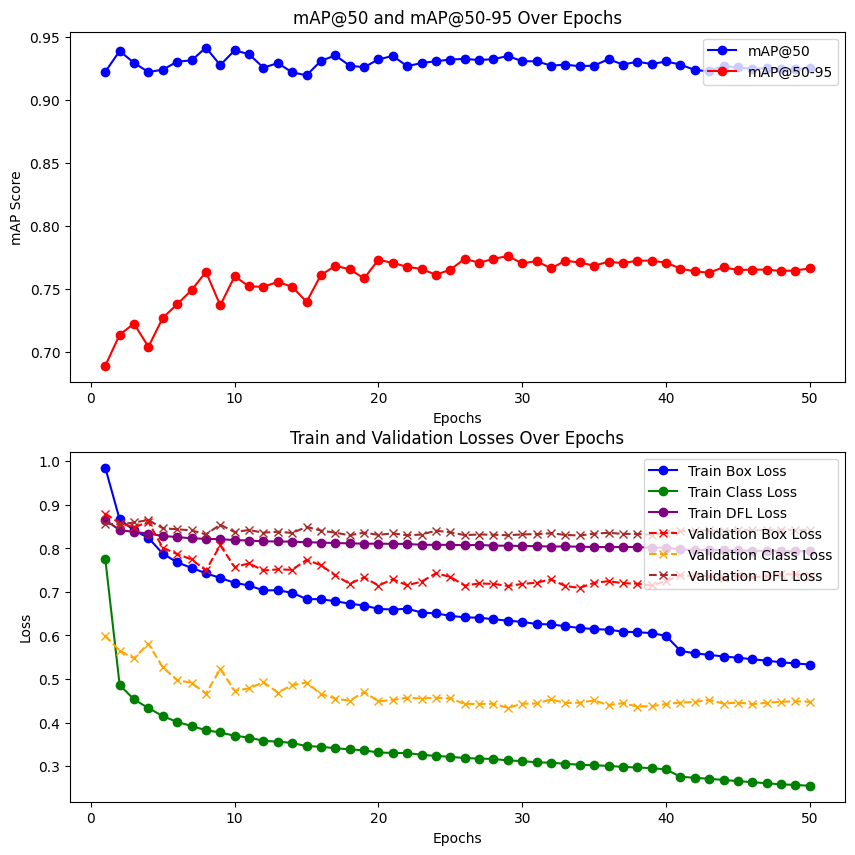

In [11]:
df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='o', color='blue')
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("mAP@50 and mAP@50-95 Over Epochs")
plt.legend(loc = 'upper right')

plt.subplot(2, 1, 2)
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", marker='o', color='blue')
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", marker='o', color='green')
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss", marker='o', color='purple')
plt.plot(df["epoch"], df["val/box_loss"], label="Validation Box Loss", marker='x', color='red', linestyle='dashed')
plt.plot(df["epoch"], df["val/cls_loss"], label="Validation Class Loss", marker='x', color='orange', linestyle='dashed')
plt.plot(df["epoch"], df["val/dfl_loss"], label="Validation DFL Loss", marker='x', color='brown', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs")
plt.legend(loc = 'upper right')

plt.show()

## Random Outputs

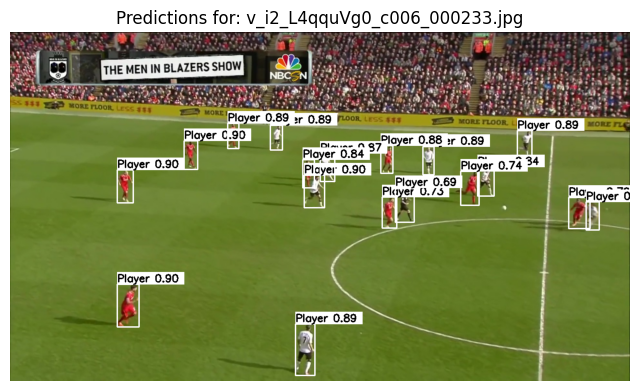

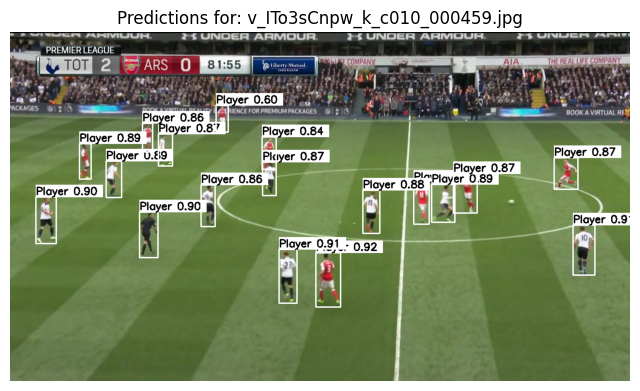

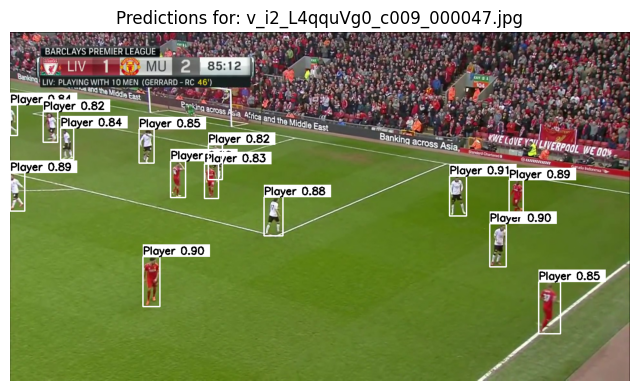

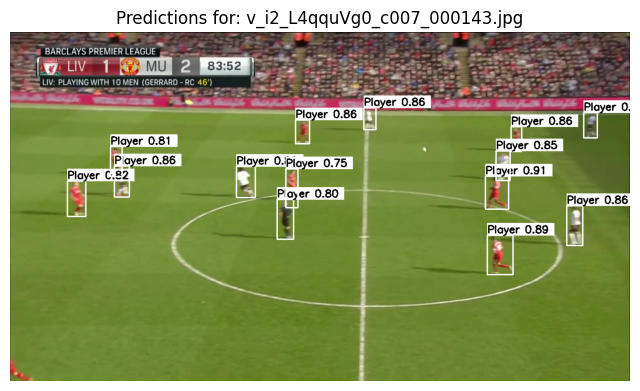

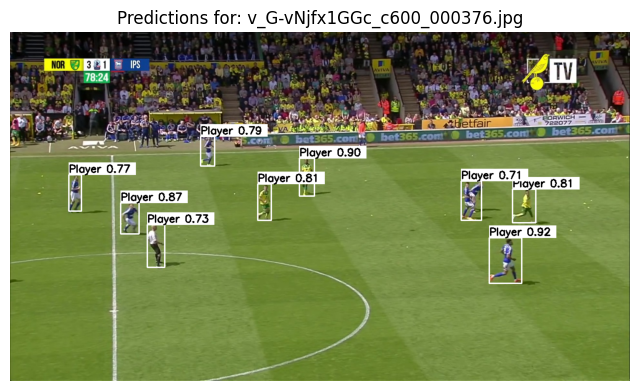

In [30]:
model = YOLO("runs/detect/train/weights/best.pt")

val_images_path = "/kaggle/working/yolo_dataset/val/images"

sample_images = random.sample(os.listdir(val_images_path), 5)

for img_name in sample_images:
    img_path = os.path.join(val_images_path, img_name)

    # Perform inference
    results = model.predict(source=img_path, conf=0.5, save=False, verbose = False)

    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract bounding boxes, confidence scores, and class IDs
    boxes = results[0].boxes.xyxy  # Bounding box coordinates
    confs = results[0].boxes.conf  # Confidence scores
    class_ids = results[0].boxes.cls.int()  # Class IDs

    # Draw bounding boxes and labels
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)  # Convert to integer

        box_color = (255, 255, 255)  # White
        text_color = (0, 0, 0)  # Black
        bg_color = (255, 255, 255)  # White background for text

        img = cv2.rectangle(img, (x1, y1), (x2, y2), box_color, 2)

        label = f"Player {confs[i]:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2
        )

        cv2.rectangle(
            img,
            (x1, y1 - text_height - baseline),
            (x1 + text_width, y1),
            bg_color,
            thickness=cv2.FILLED,
        )

        cv2.putText(
            img,
            label,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            text_color,
            2,
        )

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions for: {img_name}")
    plt.show()

## Detection Metrics

In [31]:
df = pd.read_csv("/kaggle/working//runs/detect/train/results.csv")
last_epoch = df.iloc[-1]

map_50 = float(last_epoch['metrics/mAP50(B)'])
map_50_95 = float(last_epoch['metrics/mAP50-95(B)'])
precision = float(last_epoch['metrics/precision(B)'])
recall = float(last_epoch['metrics/recall(B)'])

print("📊 YOLOv8 Validation Metrics:")
print(f"mAP@50: {map_50:.4f}")
print(f"mAP@50-95: {map_50_95:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

📊 YOLOv8 Validation Metrics:
mAP@50: 0.9258
mAP@50-95: 0.7662
Precision: 0.9178
Recall: 0.9351


## Training YOLO on Soccernet

In [34]:
# model = YOLO("yolov8n.pt")

# model.train(
#     data="/kaggle/working/yolo_dataset/soccerNet.yaml",
#     epochs=10,
#     imgsz=640
# )

model = YOLO("/kaggle/input/soccernetmodel/Best.pt")
df = pd.read_csv("/kaggle/input/soccernet/reults.csv")

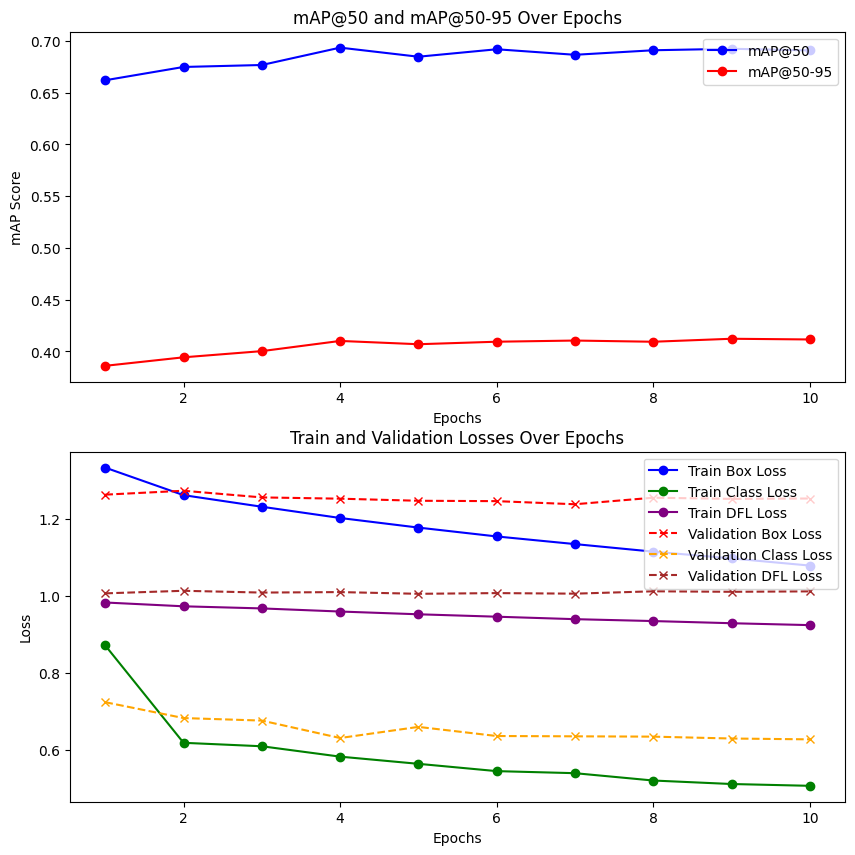

In [35]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='o', color='blue')
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("mAP@50 and mAP@50-95 Over Epochs")
plt.legend(loc = 'upper right')

plt.subplot(2, 1, 2)
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", marker='o', color='blue')
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", marker='o', color='green')
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss", marker='o', color='purple')
plt.plot(df["epoch"], df["val/box_loss"], label="Validation Box Loss", marker='x', color='red', linestyle='dashed')
plt.plot(df["epoch"], df["val/cls_loss"], label="Validation Class Loss", marker='x', color='orange', linestyle='dashed')
plt.plot(df["epoch"], df["val/dfl_loss"], label="Validation DFL Loss", marker='x', color='brown', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs")
plt.legend(loc = 'upper right')

plt.show()

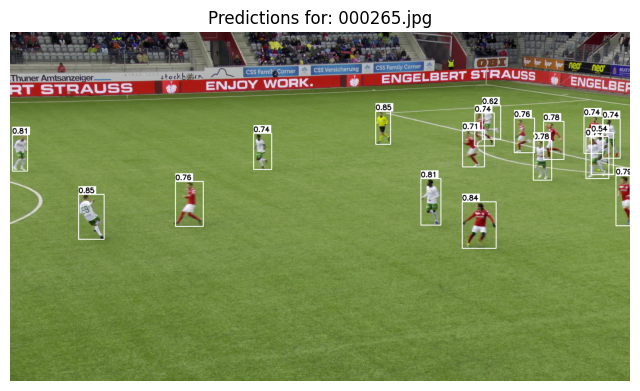

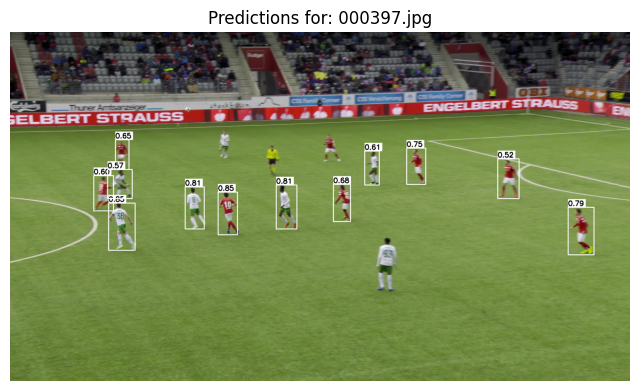

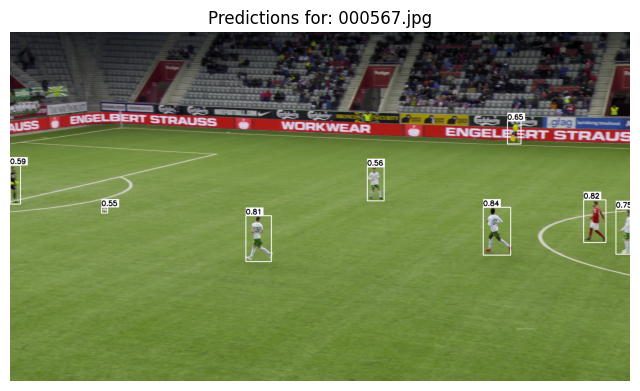

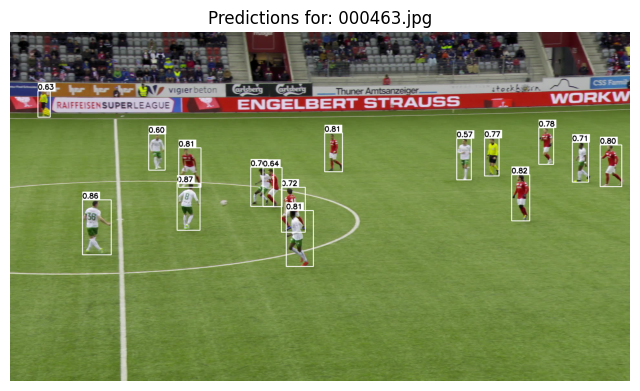

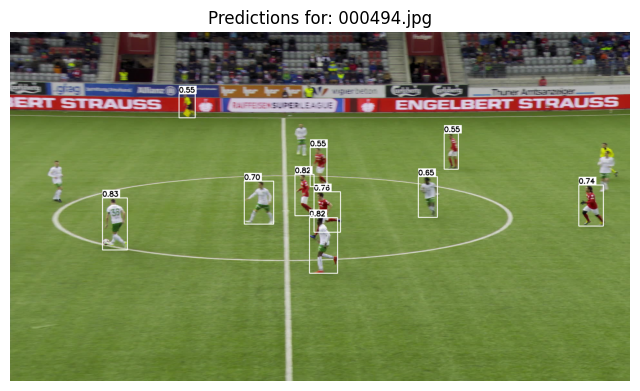

In [38]:
val_images_path = "/kaggle/input/soccernet-tracking/test/SNMOT-122/img1"

sample_images = random.sample(os.listdir(val_images_path), 5)

for img_name in sample_images:
    img_path = os.path.join(val_images_path, img_name)

    # Perform inference
    results = model.predict(source=img_path, conf=0.5, save=False, verbose = False)

    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract bounding boxes, confidence scores, and class IDs
    boxes = results[0].boxes.xyxy  # Bounding box coordinates
    confs = results[0].boxes.conf  # Confidence scores
    class_ids = results[0].boxes.cls.int()  # Class IDs

    # Draw bounding boxes and labels
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)  # Convert to integer

        box_color = (255, 255, 255)  # White
        text_color = (0, 0, 0)  # Black
        bg_color = (255, 255, 255)  # White background for text

        img = cv2.rectangle(img, (x1, y1), (x2, y2), box_color, 2)

        label = f"{confs[i]:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2
        )

        cv2.rectangle(
            img,
            (x1, y1 - text_height - baseline),
            (x1 + text_width, y1),
            bg_color,
            thickness=cv2.FILLED,
        )

        cv2.putText(
            img,
            label,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            text_color,
            2,
        )

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions for: {img_name}")
    plt.show()

In [39]:
df = pd.read_csv("/kaggle/input/soccernet/reults.csv")
last_epoch = df.iloc[-1]

map_50 = float(last_epoch['metrics/mAP50(B)'])
map_50_95 = float(last_epoch['metrics/mAP50-95(B)'])
precision = float(last_epoch['metrics/precision(B)'])
recall = float(last_epoch['metrics/recall(B)'])

print("📊 YOLOv8 Validation Metrics:")
print(f"mAP@50: {map_50:.4f}")
print(f"mAP@50-95: {map_50_95:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

📊 YOLOv8 Validation Metrics:
mAP@50: 0.6909
mAP@50-95: 0.4116
Precision: 0.8192
Recall: 0.6567


# SOT

In [13]:
import cv2
import numpy as np
from ultralytics import YOLO  # Ensure ultralytics is installed
import os
import glob


FRAMES_FOLDER = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c009/img1"  # Folder containing frame images (e.g., JPG or PNG)
OUTPUT_VIDEO_PATH = "/kaggle/working/csrt_tracked_output.mp4"
YOLO_MODEL_PATH = "/kaggle/working/runs/detect/train/weights/best.pt"  # Set your YOLO model path here
# Output video properties
FRAME_WIDTH = 1280   # Target output width (pixels)
FRAME_HEIGHT = 720   # Target output height (pixels)
FPS = 25             # Set the desired FPS for the output video

In [10]:
os.remove("/kaggle/working/csrt_tracked_video.mp4")


Previous output deleted


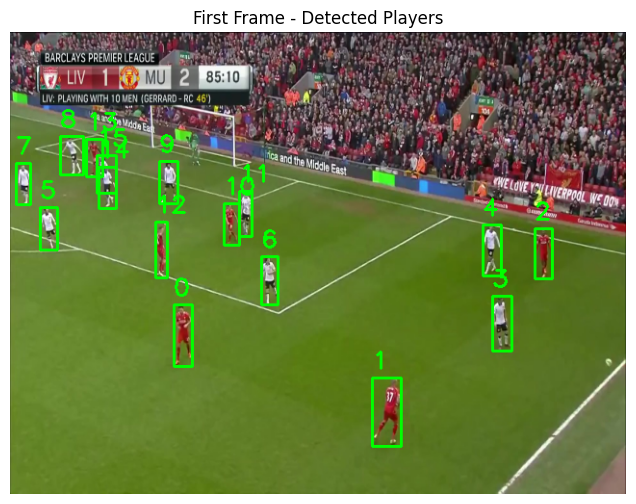

Enter the player ID (index) you want to track:  6


Selected bounding box: (261, 233, 17, 50)
Re-initialising tracker with candidate detection at frame 12: (254, 234, 18, 55)
Re-initialising tracker with candidate detection at frame 24: (251, 233, 14, 54)
Re-initialising tracker with candidate detection at frame 36: (252, 231, 18, 54)
Re-initialising tracker with candidate detection at frame 48: (262, 226, 19, 53)
Re-initialising tracker with candidate detection at frame 60: (264, 222, 20, 50)
Re-initialising tracker with candidate detection at frame 72: (257, 220, 18, 45)
Re-initialising tracker with candidate detection at frame 84: (251, 218, 20, 51)
Re-initialising tracker with candidate detection at frame 96: (257, 230, 15, 44)
Re-initialising tracker with candidate detection at frame 108: (269, 233, 19, 44)
Re-initialising tracker with candidate detection at frame 120: (290, 237, 16, 48)
Re-initialising tracker with candidate detection at frame 132: (300, 247, 24, 55)
Re-initialising tracker with candidate detection at frame 144: (

In [18]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Assuming you're using Ultralytics YOLO

# ----------------------------
# Configuration (adjust as needed)
# ----------------------------
WORKING_WIDTH = 640
WORKING_HEIGHT = 480
FRAME_WIDTH = 1280      # output video frame width
FRAME_HEIGHT = 720      # output video frame height
FPS = 25                # frames per second (adjust if needed)
redetect_interval = int(FPS * 0.5)  # every 0.5 sec
distance_threshold = 50           # in pixels
trajectory_duration_sec = 3


# ----------------------------
# Utility Functions
# ----------------------------
def get_box_bottom_centre(box):
    """Return bottom centre of a bounding box (x, y, w, h)."""
    x, y, w, h = box
    return (int(x + w / 2), int(y + h))

# ----------------------------
# Object Selection via Player ID (using matplotlib)
# ----------------------------
def select_object_by_input(frame, boxes):
    """
    Draws bounding boxes (with player IDs) on the provided frame and displays it using matplotlib.
    Prompts the user to enter a player ID corresponding to the detection they want to track.
    Returns the selected bounding box.
    """
    display_frame = frame.copy()
    for idx, box in enumerate(boxes):
        x, y, w, h = box
        cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(display_frame, f"{idx}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    display_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(display_rgb)
    plt.title("First Frame - Detected Players")
    plt.axis("off")
    plt.show()

    while True:
        try:
            player_id = int(input("Enter the player ID (index) you want to track: "))
            if 0 <= player_id < len(boxes):
                selected_box = boxes[player_id]
                print(f"Selected bounding box: {selected_box}")
                return selected_box
            else:
                print(f"Invalid input. Enter a number between 0 and {len(boxes)-1}.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

# ----------------------------
# Main Tracking Function
# ----------------------------
def main():
    # Delete previous output if it exists
    if os.path.exists(OUTPUT_VIDEO_PATH):
        os.remove(OUTPUT_VIDEO_PATH)
        print("Previous output deleted")

    # Retrieve and sort all image files in the folder.
    frame_paths = sorted(glob.glob(os.path.join(FRAMES_FOLDER, "*.*")))
    if not frame_paths:
        print("Error: No frames found in the folder.")
        return

    # Read and resize the first frame for initial detection and selection.
    first_frame = cv2.imread(frame_paths[0])
    if first_frame is None:
        print("Error: Unable to read the first frame.")
        return
    first_frame_resized = cv2.resize(first_frame, (WORKING_WIDTH, WORKING_HEIGHT))

    # Load the YOLO model.
    model = YOLO(YOLO_MODEL_PATH)

    # Run YOLO on the first frame.
    results = model(first_frame_resized, verbose=False)
    detections = results[0].boxes
    if len(detections) == 0:
        print("No detections found in the first frame. Exiting.")
        return

    # Prepare detection boxes in (x, y, w, h) format.
    boxes = []
    for det in detections:
        x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        boxes.append((x1, y1, x2 - x1, y2 - y1))

    # Let the user select the object to track.
    selected_bbox = select_object_by_input(first_frame_resized, boxes)
    if selected_bbox is None:
        print("No selection made. Exiting.")
        return

    # Initialize the CSRT tracker with the selected bounding box.
    tracker = cv2.TrackerCSRT_create()
    tracker.init(first_frame_resized, selected_bbox)

    # Manage tracking state.
    tracker_active = True      # Set to False when tracking is lost.
    last_known_box = selected_bbox

    # Prepare video writer.
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, FPS, (FRAME_WIDTH, FRAME_HEIGHT))

    # Create a blank heat map image.
    heat_map = np.zeros((WORKING_HEIGHT, WORKING_WIDTH), dtype=np.float32)

    # For tracking trajectory.
    trajectory_points = []

    # Performance counters.
    frame_count = 0
    total_frames = 0
    successful_frames = 0
    reinit_count = 0

    # Process each frame.
    for frame_path in frame_paths:
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Unable to read frame: {frame_path}. Skipping.")
            continue

        total_frames += 1
        frame_count += 1

        # Resize for processing.
        frame_resized = cv2.resize(frame, (WORKING_WIDTH, WORKING_HEIGHT))

        # Update the tracker only if it is active.
        if tracker_active:
            success, curr_box = tracker.update(frame_resized)
            if success:
                curr_box = tuple(map(int, curr_box))
                successful_frames += 1
                last_known_box = curr_box

                # Update the heat map: draw a small circle at the bottom centre.
                bottom_centre = get_box_bottom_centre(curr_box)
                cv2.circle(heat_map, bottom_centre, 5, 5, thickness=-1)

                # Append the current point to the trajectory.
                trajectory_points.append((frame_count, bottom_centre))
                trajectory_points = [
                    (f, pt) for (f, pt) in trajectory_points if (frame_count - f) <= FPS * trajectory_duration_sec
                ]
            else:
                # When tracking fails, mark tracker as inactive and stop further reinitializations.
                print(f"Tracking lost at frame {frame_count}. Stopping tracking.")
                tracker_active = False
        else:
            # Tracker is inactive: indicate lost tracking.
            cv2.putText(frame_resized, "Tracking Lost", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # ----------------------------
        # Redetection block (disabled if tracker is lost)
        # ----------------------------
        # If the tracker is still active, you might want to periodically re-detect to update the box.
        # In this modified version, we do not reinitialize the tracker once it has been lost.
        if tracker_active and (frame_count % redetect_interval == 0):
            results = model(frame_resized, verbose=False)
            detections = results[0].boxes
            if len(detections) > 0:
                tracker_bottom = get_box_bottom_centre(last_known_box)
                best_box = None
                min_distance = float('inf')
                for det in detections:
                    x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                    candidate_box = (x1, y1, x2 - x1, y2 - y1)
                    candidate_bottom = get_box_bottom_centre(candidate_box)
                    distance = np.sqrt((candidate_bottom[0] - tracker_bottom[0])**2 +
                                       (candidate_bottom[1] - tracker_bottom[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        best_box = candidate_box

                # Only reinitialize if the candidate is near the last known position.
                if best_box is not None and min_distance < distance_threshold:
                    tracker = cv2.TrackerCSRT_create()
                    tracker.init(frame_resized, best_box)
                    reinit_count += 1
                    print(f"Re-initialising tracker with candidate detection at frame {frame_count}: {best_box}")
                    last_known_box = best_box
                    # Update the heat map / trajectory on re-detection.
                    bottom_centre = get_box_bottom_centre(best_box)
                    cv2.circle(heat_map, bottom_centre, 5, 5, thickness=-1)
                    trajectory_points.append((frame_count, bottom_centre))
            # End of redetection block.

        # ----------------------------
        # Draw the tracking bounding box if active.
        # ----------------------------
        if tracker_active:
            x, y, w, h = last_known_box
            cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame_resized, "Tracking", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # In this modified version we do not overlay the heat map on each frame.
        # Instead, we simply write out the current frame (with tracking info) to the video.
        frame_output = cv2.resize(frame_resized, (FRAME_WIDTH, FRAME_HEIGHT))
        out.write(frame_output)

    # Release resources.
    out.release()
    print(f"Tracked video has been saved as: {OUTPUT_VIDEO_PATH}")
    tracking_success_rate = (successful_frames / total_frames) * 100 if total_frames > 0 else 0
    print(f"Total frames processed: {total_frames}")
    print(f"Successful tracking frames: {successful_frames} ({tracking_success_rate:.2f}%)")
    print(f"Number of tracker re-initialisations: {reinit_count}")

    # ----------------------------
    # Create and save final heat map image ("hetamao")
    # ----------------------------
    final_heat_map = cv2.GaussianBlur(heat_map, (21, 21), 0)
    final_heat_map_norm = cv2.normalize(final_heat_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    final_heat_map_coloured = cv2.applyColorMap(final_heat_map_norm, cv2.COLORMAP_JET)
    cv2.imwrite("hetamao.png", final_heat_map_coloured)
    print("Final heat map image saved as: hetamao.png")

if __name__ == '__main__':
    main()


In [35]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

class ObjectTracker:
    def __init__(self,
                 frames_folder,
                 output_video_path,
                 yolo_model_path,
                 working_width=640,
                 working_height=480,
                 frame_width=1280,
                 frame_height=720,
                 fps=25,
                 redetect_interval_sec=0.5,
                 distance_threshold=50,
                 trajectory_duration_sec=3,
                 ground_truth_path=None):
        # Configuration parameters
        self.frames_folder = frames_folder
        self.output_video_path = output_video_path
        self.yolo_model_path = yolo_model_path
        self.WORKING_WIDTH = working_width
        self.WORKING_HEIGHT = working_height
        self.FRAME_WIDTH = frame_width
        self.FRAME_HEIGHT = frame_height
        self.FPS = fps
        self.redetect_interval = int(fps * redetect_interval_sec)
        self.distance_threshold = distance_threshold
        self.trajectory_duration_sec = trajectory_duration_sec
        self.ground_truth_path = ground_truth_path

        # Initialize YOLO model
        self.model = YOLO(self.yolo_model_path)

        # Initialize other objects
        self.tracker = None
        self.tracker_active = False
        self.last_known_box = None
        self.trajectory_points = []  # list of tuples (frame_index, (x, y))
        self.heat_map = np.zeros((self.WORKING_HEIGHT, self.WORKING_WIDTH), dtype=np.float32)

        # Performance counters
        self.frame_count = 0
        self.total_frames = 0
        self.successful_frames = 0
        self.reinit_count = 0

        # Tracking metrics
        self.gt_data = {}
        self.target_id = None
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.total_iou = 0.0
        self.num_frames_with_gt = 0

        if self.ground_truth_path:
            self.gt_data = self.load_gt_data()

        # Retrieve frame paths
        self.frame_paths = sorted(glob.glob(os.path.join(self.frames_folder, "*.*")))
        if not self.frame_paths:
            raise FileNotFoundError("Error: No frames found in the folder.")


    def load_gt_data(self):
        gt_data = {}
        with open(self.ground_truth_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 6:
                    continue
                frame = int(parts[0])
                obj_id = int(parts[1])
                x, y, w, h = map(int, parts[2:6])
                if frame not in gt_data:
                    gt_data[frame] = {}
                gt_data[frame][obj_id] = (x, y, w, h)
        return gt_data

    def compute_iou(self, box1, box2):
        x1_1, y1_1, w1, h1 = box1
        x2_1 = x1_1 + w1
        y2_1 = y1_1 + h1

        x1_2, y1_2, w2, h2 = box2
        x2_2 = x1_2 + w2
        y2_2 = y1_2 + h2

        x_left = max(x1_1, x1_2)
        y_top = max(y1_1, y1_2)
        x_right = min(x2_1, x2_2)
        y_bottom = min(y2_1, y2_2)

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        box1_area = w1 * h1
        box2_area = w2 * h2
        union_area = box1_area + box2_area - intersection_area

        return intersection_area / union_area if union_area else 0.0

    @staticmethod
    def get_box_bottom_centre(box):
        x, y, w, h = box
        return (int(x + w / 2), int(y + h))


    def initialize_tracker(self, initial_frame, selected_bbox):
        """Initialize the CSRT tracker with the given bounding box."""
        self.tracker = cv2.TrackerCSRT_create()
        self.tracker.init(initial_frame, selected_bbox)
        self.tracker_active = True
        self.last_known_box = selected_bbox

    @staticmethod
    def select_object_by_input(frame, boxes):
        display_frame = frame.copy()
        for idx, box in enumerate(boxes):
            x, y, w, h = box
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(display_frame, f"{idx}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        display_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 12))
        plt.imshow(display_rgb)
        plt.title("First Frame - Detected Players")
        plt.axis("off")
        plt.show()

        while True:
            try:
                player_id = int(input("Enter the player ID (index) you want to track: "))
                if 0 <= player_id < len(boxes):
                    return boxes[player_id]
                print(f"Invalid input. Enter a number between 0 and {len(boxes)-1}.")
            except ValueError:
                print("Invalid input. Please enter an integer.")


    def process_first_frame(self):
        """Process the first frame to perform initial detection and object selection."""
        first_frame = cv2.imread(self.frame_paths[0])
        if first_frame is None:
            raise IOError("Error: Unable to read the first frame.")
        first_frame_resized = cv2.resize(first_frame, (self.WORKING_WIDTH, self.WORKING_HEIGHT))

        # Run YOLO on the first frame.
        results = self.model(first_frame_resized, verbose=False)
        detections = results[0].boxes
        if len(detections) == 0:
            raise ValueError("No detections found in the first frame. Exiting.")

        boxes = []
        for det in detections:
            x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            boxes.append((x1, y1, x2 - x1, y2 - y1))

        # Let the user select the object to track.
        selected_bbox = ObjectTracker.select_object_by_input(first_frame_resized, boxes)
        self.initialize_tracker(first_frame_resized, selected_bbox)
        if self.ground_truth_path:
            gt_frame = 1  # Since the first processed frame is index 0 (GT is 1-based)
            if gt_frame in self.gt_data:
                max_iou = 0.0
                best_id = None
        
                # Scale factors from original frame size to working size
                scale_x = self.WORKING_WIDTH / self.FRAME_WIDTH
                scale_y = self.WORKING_HEIGHT / self.FRAME_HEIGHT
        
                for obj_id, gt_box in self.gt_data[gt_frame].items():
                    # Scale the ground truth box to working dimensions
                    x = int(gt_box[0] * scale_x)
                    y = int(gt_box[1] * scale_y)
                    w = int(gt_box[2] * scale_x)
                    h = int(gt_box[3] * scale_y)
                    scaled_gt_box = (x, y, w, h)
        
                    # Compute IoU between the selected box and this GT box
                    iou = self.compute_iou(selected_bbox, scaled_gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        best_id = obj_id
        
                if max_iou >= 0.5:
                    self.target_id = best_id
                    print(f"Matched selected object with GT ID {best_id} (IoU: {max_iou:.2f})")
                else:
                    print("Warning: Selected object does not match any GT with IoU ≥0.5. Metrics disabled.")
                    self.target_id = None
            else:
                print(f"Warning: GT data not available for frame {gt_frame}. Metrics disabled.")
                self.target_id = None
        else:
            self.target_id = None

    def redetect(self, frame_resized):
        """Attempt to re-detect the object every so many frames if the tracker is still active."""
        results = self.model(frame_resized, verbose=False)
        detections = results[0].boxes
        if len(detections) == 0:
            return

        tracker_bottom = ObjectTracker.get_box_bottom_centre(self.last_known_box)
        best_box = None
        min_distance = float('inf')

        for det in detections:
            x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            candidate_box = (x1, y1, x2 - x1, y2 - y1)
            candidate_bottom = ObjectTracker.get_box_bottom_centre(candidate_box)
            distance = np.sqrt((candidate_bottom[0] - tracker_bottom[0]) ** 2 +
                               (candidate_bottom[1] - tracker_bottom[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                best_box = candidate_box

        if best_box is not None and min_distance < self.distance_threshold:
            self.tracker = cv2.TrackerCSRT_create()
            self.tracker.init(frame_resized, best_box)
            self.reinit_count += 1
            # print(f"Re-initialising tracker with candidate detection at frame {self.frame_count}: {best_box}")
            self.last_known_box = best_box

            bottom_centre = ObjectTracker.get_box_bottom_centre(best_box)
            cv2.circle(self.heat_map, bottom_centre, 5, 5, thickness=-1)
            self.trajectory_points.append((self.frame_count, bottom_centre))

    def update_trajectory(self, bottom_centre):
        """Append current bottom centre to trajectory and prune old points."""
        self.trajectory_points.append((self.frame_count, bottom_centre))
        self.trajectory_points = [
            (f, pt) for (f, pt) in self.trajectory_points
            if (self.frame_count - f) <= self.FPS * self.trajectory_duration_sec
        ]


    def update_metrics(self, frame_count):
        if not self.ground_truth_path or self.target_id is None:
            return

        gt_frame = frame_count + 1  # Assuming 1-based GT frames
        if gt_frame not in self.gt_data or self.target_id not in self.gt_data[gt_frame]:
            return

        scale_x = self.WORKING_WIDTH / self.FRAME_WIDTH
        scale_y = self.WORKING_HEIGHT / self.FRAME_HEIGHT
        gt_box = self.gt_data[gt_frame][self.target_id]
        scaled_gt = (gt_box[0] * scale_x, gt_box[1] * scale_y,
                     gt_box[2] * scale_x, gt_box[3] * scale_y)
        scaled_gt = tuple(map(int, scaled_gt))

        self.num_frames_with_gt += 1
        
        if self.tracker_active and self.last_known_box:
            iou = self.compute_iou(self.last_known_box, scaled_gt)
            self.total_iou += iou
            if iou >= 0.5:
                self.tp += 1
            else:
                self.fp += 1
        else:
            self.fn += 1

    def process_frames(self):
        """Process all frames: tracking, redetection, heat map update, and video writing."""
        # Prepare video writer.
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(self.output_video_path, fourcc, self.FPS, (self.FRAME_WIDTH, self.FRAME_HEIGHT))

        for frame_path in self.frame_paths:
            frame = cv2.imread(frame_path)
            if frame is None:
                print(f"Warning: Unable to read frame: {frame_path}. Skipping.")
                continue

            self.update_metrics(self.frame_count)
            self.total_frames += 1
            self.frame_count += 1

            frame_resized = cv2.resize(frame, (self.WORKING_WIDTH, self.WORKING_HEIGHT))

            if self.tracker_active:
                success, curr_box = self.tracker.update(frame_resized)
                if success:
                    curr_box = tuple(map(int, curr_box))
                    self.successful_frames += 1
                    self.last_known_box = curr_box

                    bottom_centre = ObjectTracker.get_box_bottom_centre(curr_box)
                    cv2.circle(self.heat_map, bottom_centre, 5, 5, thickness=-1)
                    self.update_trajectory(bottom_centre)
                else:
                    print(f"Tracking lost at frame {self.frame_count}. Stopping tracking.")
                    self.tracker_active = False
            else:
                cv2.putText(frame_resized, "Tracking Lost", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            if self.tracker_active and (self.frame_count % self.redetect_interval == 0):
                self.redetect(frame_resized)

            # Draw tracking bounding box if active.
            if self.tracker_active:
                x, y, w, h = self.last_known_box
                cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame_resized, "Tracking", (x, y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Draw trajectory (last few seconds).
            if len(self.trajectory_points) > 1:
                sorted_points = sorted(self.trajectory_points, key=lambda t: t[0])
                for i in range(1, len(sorted_points)):
                    pt1 = sorted_points[i - 1][1]
                    pt2 = sorted_points[i][1]
                    cv2.line(frame_resized, pt1, pt2, (255, 255, 255), 2)

            # Write the frame to the video writer (resize to target output resolution).
            frame_output = cv2.resize(frame_resized, (self.FRAME_WIDTH, self.FRAME_HEIGHT))
            out.write(frame_output)

        out.release()

    def print_statistics(self):
        print(f"\nTracking Statistics:")
        print(f"Total frames processed: {self.total_frames}")
        print(f"Successful tracking frames: {self.successful_frames} ({self.successful_frames/self.total_frames:.2%})")
        print(f"Reinitializations: {self.reinit_count}")

        if self.ground_truth_path and self.num_frames_with_gt > 0:
            avg_iou = self.total_iou / self.num_frames_with_gt
            precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) else 0
            recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

            print("\nPerformance Metrics:")
            print(f"Average IoU: {avg_iou:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")

    def plot_heatmap(self):
        """Plot the final heat map using matplotlib."""
        final_heat_map = cv2.GaussianBlur(self.heat_map, (21, 21), 0)
        final_heat_map_norm = cv2.normalize(final_heat_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        final_heat_map_coloured = cv2.applyColorMap(final_heat_map_norm, cv2.COLORMAP_JET)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(final_heat_map_coloured, cv2.COLOR_BGR2RGB))
        plt.title("Heat Map")
        plt.axis("off")
        plt.show()

    def update_box_heatmap(self, box):
        """Update the heatmap for the bounding box region."""
        x, y, w, h = box
        # Draw heatmap points within the bounding box region
        for i in range(x, x + w, 5):  # Step size of 5 for better heatmap density
            for j in range(y, y + h, 5):
                cv2.circle(self.heat_map, (i, j), 3, 1, thickness=-1)

    def plot_heatmap2(self):
        """Plot the final heat map using matplotlib."""
        final_heat_map = cv2.GaussianBlur(self.heat_map, (21, 21), 0)
        final_heat_map_norm = cv2.normalize(final_heat_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        final_heat_map_coloured = cv2.applyColorMap(final_heat_map_norm, cv2.COLORMAP_JET)
    
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(final_heat_map_coloured, cv2.COLOR_BGR2RGB))
        plt.title("Heat Map - Including Bounding Boxes")
        plt.axis("off")
        plt.show()


    def run(self):
        """Run the entire tracking pipeline."""
        # Remove previous output if it exists.
        if os.path.exists(self.output_video_path):
            os.remove(self.output_video_path)
        # Process first frame to detect and select the object.
        self.process_first_frame()
        # Process all frames.
        self.process_frames()
        # Plot the final heat map.
        self.plot_heatmap()
        self.print_statistics()

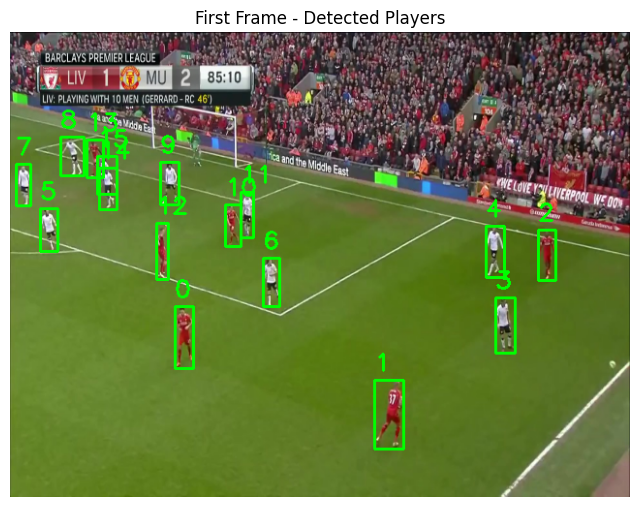

Enter the player ID (index) you want to track:  6


Matched selected object with GT ID 5 (IoU: 0.80)
Tracking lost at frame 487. Stopping tracking.


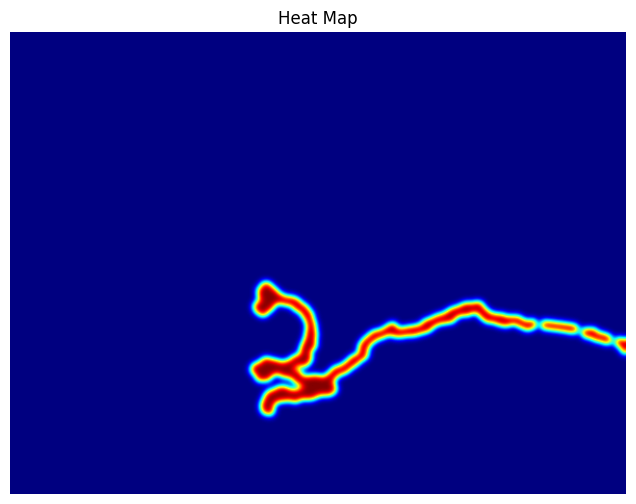


Tracking Statistics:
Total frames processed: 488
Successful tracking frames: 486 (99.59%)
Reinitializations: 40

Performance Metrics:
Average IoU: 0.7081
Precision: 0.9239
Recall: 1.0000
F1 Score: 0.9604


In [36]:
FRAMES_FOLDER = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c009/img1"  
OUTPUT_VIDEO_PATH = "/kaggle/working/csrt_tracked.mp4"
YOLO_MODEL_PATH = "/kaggle/input/best-model-yolo/best.pt"
GT_FILE = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c009/gt/gt.txt"

tracker = ObjectTracker(
    frames_folder=FRAMES_FOLDER,
    output_video_path=OUTPUT_VIDEO_PATH,
    yolo_model_path=YOLO_MODEL_PATH,
    working_width=640,
    working_height=480,
    frame_width=1280,
    frame_height=720,
    fps=25,
    redetect_interval_sec=0.5,
    distance_threshold=50,
    trajectory_duration_sec=3,
    ground_truth_path=GT_FILE  
)
tracker.run()

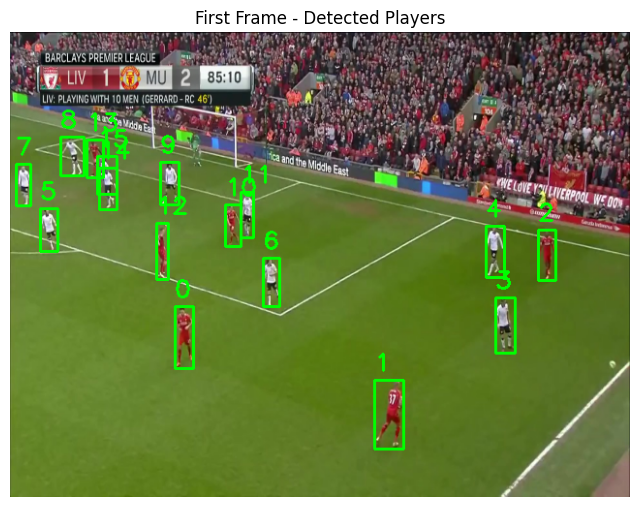

Enter the player ID (index) you want to track:  2


Tracking lost at frame 153. Stopping tracking.


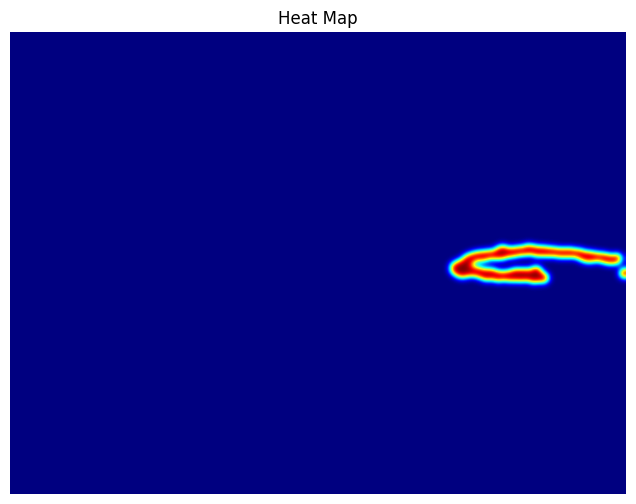


Tracking Statistics:
Total frames processed: 488
Successful tracking frames: 152 (31.15%)
Reinitializations: 12


In [27]:
FRAMES_FOLDER = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c009/img1"  
OUTPUT_VIDEO_PATH = "/kaggle/working/csrt_tracked(out of scene).mp4"
YOLO_MODEL_PATH = "/kaggle/input/best-model-yolo/best.pt"
GT_FILE = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c009/gt/gt.txt"

tracker = ObjectTracker(
    frames_folder=FRAMES_FOLDER,
    output_video_path=OUTPUT_VIDEO_PATH,
    yolo_model_path=YOLO_MODEL_PATH,
    working_width=640,
    working_height=480,
    frame_width=1280,
    frame_height=720,
    fps=25,
    redetect_interval_sec=0.5,
    distance_threshold=50,
    trajectory_duration_sec=3
)
tracker.run()

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

class ObjectTracker:
    def __init__(self,
                 video_path,
                 output_video_path,
                 yolo_model_path,
                 working_width=640,
                 working_height=480,
                 frame_width=1280,
                 frame_height=720,
                 fps=25,
                 redetect_interval_sec=0.5,
                 distance_threshold=50,
                 trajectory_duration_sec=3,
                 ground_truth_path=None):
        # Configuration parameters
        self.video_path = video_path
        self.output_video_path = output_video_path
        self.yolo_model_path = yolo_model_path
        self.WORKING_WIDTH = working_width
        self.WORKING_HEIGHT = working_height
        self.FRAME_WIDTH = frame_width
        self.FRAME_HEIGHT = frame_height
        self.FPS = fps
        self.redetect_interval = int(fps * redetect_interval_sec)
        self.distance_threshold = distance_threshold
        self.trajectory_duration_sec = trajectory_duration_sec
        self.ground_truth_path = ground_truth_path

        # Initialize YOLO model
        self.model = YOLO(self.yolo_model_path)

        # Initialize other objects
        self.tracker = None
        self.tracker_active = False
        self.last_known_box = None
        self.trajectory_points = []  # list of tuples (frame_index, (x, y))
        self.heat_map = np.zeros((self.WORKING_HEIGHT, self.WORKING_WIDTH), dtype=np.float32)

        # Performance counters
        self.frame_count = 0
        self.total_frames = 0
        self.successful_frames = 0
        self.reinit_count = 0

        # Tracking metrics
        self.gt_data = {}
        self.target_id = None
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.total_iou = 0.0
        self.num_frames_with_gt = 0

        if self.ground_truth_path:
            self.gt_data = self.load_gt_data()

        # Ensure the input video exists.
        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Error: Video file '{self.video_path}' not found.")

    def load_gt_data(self):
        gt_data = {}
        with open(self.ground_truth_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 6:
                    continue
                frame = int(parts[0])
                obj_id = int(parts[1])
                x, y, w, h = map(int, parts[2:6])
                if frame not in gt_data:
                    gt_data[frame] = {}
                gt_data[frame][obj_id] = (x, y, w, h)
        return gt_data

    def compute_iou(self, box1, box2):
        x1_1, y1_1, w1, h1 = box1
        x2_1 = x1_1 + w1
        y2_1 = y1_1 + h1

        x1_2, y1_2, w2, h2 = box2
        x2_2 = x1_2 + w2
        y2_2 = y1_2 + h2

        x_left = max(x1_1, x1_2)
        y_top = max(y1_1, y1_2)
        x_right = min(x2_1, x2_2)
        y_bottom = min(y2_1, y2_2)

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        box1_area = w1 * h1
        box2_area = w2 * h2
        union_area = box1_area + box2_area - intersection_area

        return intersection_area / union_area if union_area else 0.0

    @staticmethod
    def get_box_bottom_centre(box):
        x, y, w, h = box
        return (int(x + w / 2), int(y + h))

    def initialize_tracker(self, initial_frame, selected_bbox):
        """Initialize the CSRT tracker with the given bounding box."""
        self.tracker = cv2.TrackerCSRT_create()
        self.tracker.init(initial_frame, selected_bbox)
        self.tracker_active = True
        self.last_known_box = selected_bbox

    @staticmethod
    def select_object_by_input(frame, boxes):
        display_frame = frame.copy()
        for idx, box in enumerate(boxes):
            x, y, w, h = box
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(display_frame, f"{idx}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        display_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 12))
        plt.imshow(display_rgb)
        plt.title("First Frame - Detected Players")
        plt.axis("off")
        plt.show()

        while True:
            try:
                player_id = int(input("Enter the player ID (index) you want to track: "))
                if 0 <= player_id < len(boxes):
                    return boxes[player_id]
                print(f"Invalid input. Enter a number between 0 and {len(boxes)-1}.")
            except ValueError:
                print("Invalid input. Please enter an integer.")

    def process_first_frame(self, cap):
        """Process the first frame to perform initial detection and object selection."""
        ret, first_frame = cap.read()
        if not ret or first_frame is None:
            raise IOError("Error: Unable to read the first frame from the video.")
        first_frame_resized = cv2.resize(first_frame, (self.WORKING_WIDTH, self.WORKING_HEIGHT))

        # Run YOLO on the first frame.
        results = self.model(first_frame_resized, verbose=False)
        detections = results[0].boxes
        if len(detections) == 0:
            raise ValueError("No detections found in the first frame. Exiting.")

        boxes = []
        for det in detections:
            x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            boxes.append((x1, y1, x2 - x1, y2 - y1))

        # Let the user select the object to track.
        selected_bbox = ObjectTracker.select_object_by_input(first_frame_resized, boxes)
        self.initialize_tracker(first_frame_resized, selected_bbox)

        if self.ground_truth_path:
            gt_frame = 1  # Since the first processed frame is index 0 (GT is 1-based)
            if gt_frame in self.gt_data:
                max_iou = 0.0
                best_id = None

                # Scale factors from original frame size to working size
                scale_x = self.WORKING_WIDTH / self.FRAME_WIDTH
                scale_y = self.WORKING_HEIGHT / self.FRAME_HEIGHT

                for obj_id, gt_box in self.gt_data[gt_frame].items():
                    # Scale the ground truth box to working dimensions
                    x = int(gt_box[0] * scale_x)
                    y = int(gt_box[1] * scale_y)
                    w = int(gt_box[2] * scale_x)
                    h = int(gt_box[3] * scale_y)
                    scaled_gt_box = (x, y, w, h)

                    # Compute IoU between the selected box and this GT box
                    iou = self.compute_iou(selected_bbox, scaled_gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        best_id = obj_id

                if max_iou >= 0.5:
                    self.target_id = best_id
                    print(f"Matched selected object with GT ID {best_id} (IoU: {max_iou:.2f})")
                else:
                    print("Warning: Selected object does not match any GT with IoU ≥0.5. Metrics disabled.")
                    self.target_id = None
            else:
                print(f"Warning: GT data not available for frame {gt_frame}. Metrics disabled.")
                self.target_id = None
        else:
            self.target_id = None

    def redetect(self, frame_resized):
        """Attempt to re-detect the object every so many frames if the tracker is still active."""
        results = self.model(frame_resized, verbose=False)
        detections = results[0].boxes
        if len(detections) == 0:
            return

        tracker_bottom = ObjectTracker.get_box_bottom_centre(self.last_known_box)
        best_box = None
        min_distance = float('inf')

        for det in detections:
            x1, y1, x2, y2 = det.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            candidate_box = (x1, y1, x2 - x1, y2 - y1)
            candidate_bottom = ObjectTracker.get_box_bottom_centre(candidate_box)
            distance = np.sqrt((candidate_bottom[0] - tracker_bottom[0]) ** 2 +
                               (candidate_bottom[1] - tracker_bottom[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                best_box = candidate_box

        if best_box is not None and min_distance < self.distance_threshold:
            self.tracker = cv2.TrackerCSRT_create()
            self.tracker.init(frame_resized, best_box)
            self.reinit_count += 1
            # Re-initialise the tracker with the candidate detection.
            self.last_known_box = best_box

            bottom_centre = ObjectTracker.get_box_bottom_centre(best_box)
            cv2.circle(self.heat_map, bottom_centre, 5, 5, thickness=-1)
            self.trajectory_points.append((self.frame_count, bottom_centre))

    def update_trajectory(self, bottom_centre):
        """Append current bottom centre to trajectory and prune old points."""
        self.trajectory_points.append((self.frame_count, bottom_centre))
        self.trajectory_points = [
            (f, pt) for (f, pt) in self.trajectory_points
            if (self.frame_count - f) <= self.FPS * self.trajectory_duration_sec
        ]

    def update_metrics(self, frame_count):
        if not self.ground_truth_path or self.target_id is None:
            return

        gt_frame = frame_count + 1  # Assuming 1-based GT frames
        if gt_frame not in self.gt_data or self.target_id not in self.gt_data[gt_frame]:
            return

        scale_x = self.WORKING_WIDTH / self.FRAME_WIDTH
        scale_y = self.WORKING_HEIGHT / self.FRAME_HEIGHT
        gt_box = self.gt_data[gt_frame][self.target_id]
        scaled_gt = (gt_box[0] * scale_x, gt_box[1] * scale_y,
                     gt_box[2] * scale_x, gt_box[3] * scale_y)
        scaled_gt = tuple(map(int, scaled_gt))

        self.num_frames_with_gt += 1

        if self.tracker_active and self.last_known_box:
            iou = self.compute_iou(self.last_known_box, scaled_gt)
            self.total_iou += iou
            if iou >= 0.5:
                self.tp += 1
            else:
                self.fp += 1
        else:
            self.fn += 1

    def process_frames(self, cap):
        """Process all frames: tracking, redetection, heat map update, trajectory drawing, and video writing."""
        # Prepare video writer.
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(self.output_video_path, fourcc, self.FPS, (self.FRAME_WIDTH, self.FRAME_HEIGHT))

        while True:
            ret, frame = cap.read()
            if not ret or frame is None:
                break

            self.update_metrics(self.frame_count)
            self.total_frames += 1
            self.frame_count += 1

            frame_resized = cv2.resize(frame, (self.WORKING_WIDTH, self.WORKING_HEIGHT))

            if self.tracker_active:
                success, curr_box = self.tracker.update(frame_resized)
                if success:
                    curr_box = tuple(map(int, curr_box))
                    self.successful_frames += 1
                    self.last_known_box = curr_box

                    bottom_centre = ObjectTracker.get_box_bottom_centre(curr_box)
                    cv2.circle(self.heat_map, bottom_centre, 5, 5, thickness=-1)
                    self.update_trajectory(bottom_centre)
                else:
                    print(f"Tracking lost at frame {self.frame_count}. Stopping tracking.")
                    self.tracker_active = False
            else:
                cv2.putText(frame_resized, "Tracking Lost", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                # Gradually diminish the heat map when tracking is lost.
                self.heat_map = self.heat_map * 0.98

            if self.tracker_active and (self.frame_count % self.redetect_interval == 0):
                self.redetect(frame_resized)

            # Draw tracking bounding box if active.
            if self.tracker_active:
                x, y, w, h = self.last_known_box
                cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame_resized, "Tracking", (x, y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # # Draw trajectory (last few seconds).
            # if len(self.trajectory_points) > 1:
            #     sorted_points = sorted(self.trajectory_points, key=lambda t: t[0])
            #     for i in range(1, len(sorted_points)):
            #         pt1 = sorted_points[i - 1][1]
            #         pt2 = sorted_points[i][1]
            #         cv2.line(frame_resized, pt1, pt2, (255, 255, 255), 2)

            # Write the frame to the video writer (resize to target output resolution).
            frame_output = cv2.resize(frame_resized, (self.FRAME_WIDTH, self.FRAME_HEIGHT))
            out.write(frame_output)

        out.release()

    def print_statistics(self):
        print(f"\nTracking Statistics:")
        print(f"Total frames processed: {self.total_frames}")
        print(f"Successful tracking frames: {self.successful_frames} ({self.successful_frames/self.total_frames:.2%})")
        print(f"Reinitializations: {self.reinit_count}")

        if self.ground_truth_path and self.num_frames_with_gt > 0:
            avg_iou = self.total_iou / self.num_frames_with_gt
            precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) else 0
            recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

            print("\nPerformance Metrics:")
            print(f"Average IoU: {avg_iou:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")

    def plot_heatmap(self):
        """Plot the final heat map using matplotlib."""
        final_heat_map = cv2.GaussianBlur(self.heat_map, (21, 21), 0)
        final_heat_map_norm = cv2.normalize(final_heat_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        final_heat_map_coloured = cv2.applyColorMap(final_heat_map_norm, cv2.COLORMAP_JET)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(final_heat_map_coloured, cv2.COLOR_BGR2RGB))
        plt.title("Heat Map")
        plt.axis("off")
        plt.show()

    def update_box_heatmap(self, box):
        """Update the heatmap for the bounding box region."""
        x, y, w, h = box
        # Draw heatmap points within the bounding box region
        for i in range(x, x + w, 5):  # Step size of 5 for better heatmap density
            for j in range(y, y + h, 5):
                cv2.circle(self.heat_map, (i, j), 3, 1, thickness=-1)

    def plot_heatmap2(self):
        """Plot the final heat map (including bounding boxes) using matplotlib."""
        final_heat_map = cv2.GaussianBlur(self.heat_map, (21, 21), 0)
        final_heat_map_norm = cv2.normalize(final_heat_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        final_heat_map_coloured = cv2.applyColorMap(final_heat_map_norm, cv2.COLORMAP_JET)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(final_heat_map_coloured, cv2.COLOR_BGR2RGB))
        plt.title("Heat Map - Including Bounding Boxes")
        plt.axis("off")
        plt.show()

    def run(self):
        """Run the entire tracking pipeline."""
        # Remove previous output if it exists.
        if os.path.exists(self.output_video_path):
            os.remove(self.output_video_path)

        # Open the video file.
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            raise IOError(f"Error: Unable to open video file '{self.video_path}'.")

        # Process first frame to detect and select the object.
        self.process_first_frame(cap)

        # Process all frames.
        self.process_frames(cap)

        # Plot the final heat map.
        self.plot_heatmap()
        self.print_statistics()

        # Release the video capture.
        cap.release()

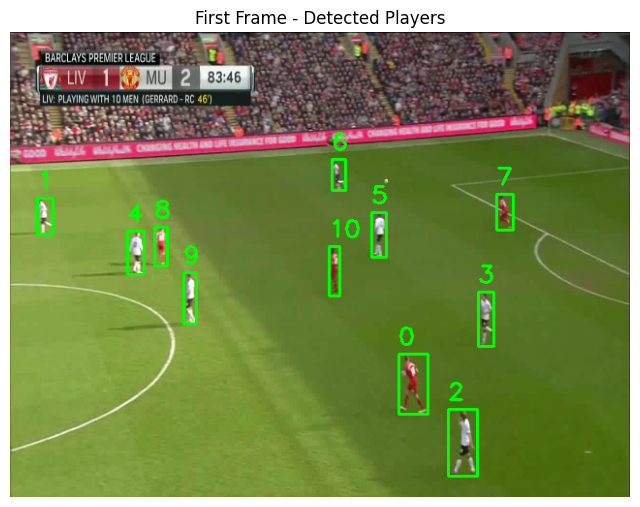

Enter the player ID (index) you want to track:  10


Tracking lost at frame 160. Stopping tracking.


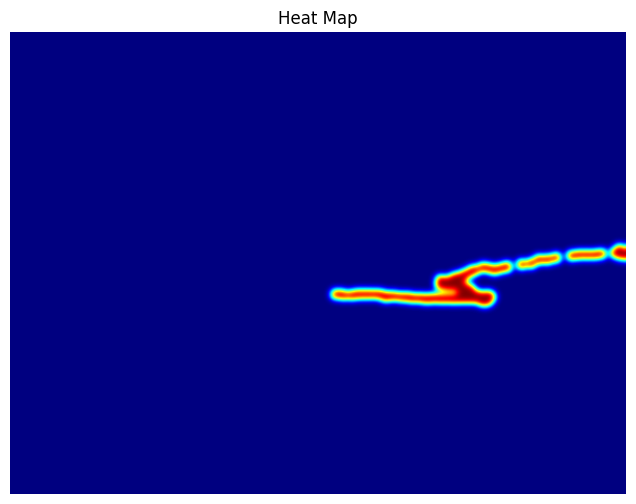


Tracking Statistics:
Total frames processed: 450
Successful tracking frames: 159 (35.33%)
Reinitializations: 13


In [11]:
VIDEO_PATH = "/kaggle/input/val-video/val_video.mp4"  
OUTPUT_VIDEO_PATH = "/kaggle/working/csrt_tracked_video.mp4"
YOLO_MODEL_PATH = "/kaggle/input/best-model-yolo/best.pt"
# If ground truth is not available, set GT_FILE to None.
GT_FILE = None  # or provide the ground truth file path

tracker = ObjectTracker(
    video_path=VIDEO_PATH,
    output_video_path=OUTPUT_VIDEO_PATH,
    yolo_model_path=YOLO_MODEL_PATH,
    working_width=640,
    working_height=480,
    frame_width=1280,
    frame_height=720,
    fps=25,
    redetect_interval_sec=0.5,
    distance_threshold=50,
    trajectory_duration_sec=3,
    ground_truth_path=GT_FILE  
)
tracker.run()